In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import queue
from multiprocessing import Pool
import os

import sys
backtest_dir = 'C://backtest/backtest/'
if backtest_dir not in sys.path:
    sys.path.insert(0, backtest_dir)
    
from Backtest import *
from BayesianOptimization import *
from Backtest.open_json_gz_files import open_json_gz_files
from Backtest.generate_bars import generate_bars

---------------------------------
ADXStrategy_18
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2018-02-01 00:00:00
	End Date	: 2018-08-07 23:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.1489832363
Sortino Ratio: 0.3038578742
Information Ratio: 0.5317523479
Max Drawdown: 0.4445662135
Max Drawdown Duration: 356400
Total Returns: -0.0290871097
Annualized Returns: -0.0564848329
Compound Annual Growth Rate: -0.0557106158
---------------------------------
Trades: 183
Trade Winning: 36.61%
Average Trade: 0.22%
Average Win: 2.36%
Average Loss: -1.01%
Best Trade: 23.08%
Worst Trade: -5.34%
Worst Trade Date: 2.0
Avg Days in Trade: 11.51361111111111
---------------------------------


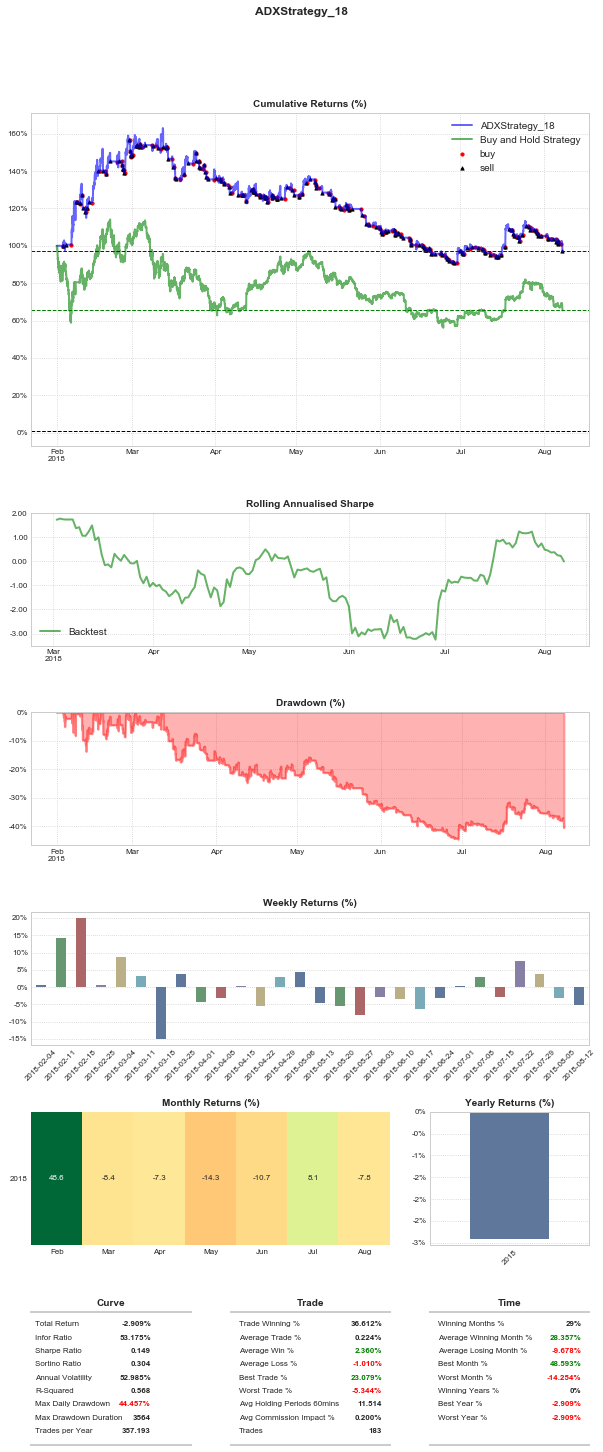

In [3]:

class ADXStrategy(Strategy):
    def __init__(self, config, events, data_handler,
                 window = 10):
        self.config = config
        self.data_handler = data_handler
        self.tickers = self.config['tickers']
        self.events = events
        self.holdinds = self._calculate_initial_holdings()
        self.start_date = self.config['start_date']
        self.end_date = self.config['end_date']

        self.window = (window - 1) * pd.to_timedelta(str(data_handler.freq) + "Min")
        self.hd = pd.Series(0, index = data_handler.times[self.start_date: self.end_date])
        self.ld = pd.Series(0, index = data_handler.times[self.start_date: self.end_date])

    def _calculate_initial_holdings(self):
        holdings = {}
        for s in self.tickers:
            holdings[s] = "EMPTY"
        return holdings

    def _get_hdld(self, bars_high, bars_low, bar_date):
        a = bars_high[-1] - bars_high[-2]
        b = bars_low[-2] - bars_low[-1]
        if a > 0 and a > b:
            self.hd[bar_date] = a
        else:
            self.hd[bar_date] = 0
        if b > 0 and b > a:
            self.ld[bar_date] = b
        else:
            self.ld[bar_date] = 0

        hd_mean = np.mean(self.hd[bar_date - self.window: bar_date])
        ld_mean = np.mean(self.ld[bar_date - self.window: bar_date])
        return hd_mean, ld_mean

    def generate_signals(self, event):
        if event.type == EventType.MARKET:
            ticker = event.ticker
            bar_date = event.timestamp
            bars_high = self.data_handler.get_latest_bars_values(ticker, "high", N = 2)
            bars_low = self.data_handler.get_latest_bars_values(ticker, "low", N = 2)

            if len(bars_high) > 1:
                hd_mean, ld_mean = self._get_hdld(bars_high, bars_low, bar_date)
                if hd_mean - ld_mean > 0 and self.holdinds[ticker] == "EMPTY":
                    self.generate_buy_signals(ticker, bar_date, "LONG")
                    self.holdinds[ticker] = "HOLD"
                elif hd_mean - ld_mean < 0 and self.holdinds[ticker] == "HOLD":
                    self.generate_sell_signals(ticker, bar_date, "SHORT")
                    self.holdinds[ticker] = "EMPTY"
            else:
                self.hd[bar_date] = 0
                self.ld[bar_date] = 0

def run_backtest(config, trading_data, ohlc_data, window = 10):
    config['title'] = "ADXStrategy" + "_" + str(window)
    print("---------------------------------")
    print(config['title'])
    print("---------------------------------")
    
    events_queue = queue.Queue()

    data_handler = OHLCDataHandler(
        config, events_queue,
        trading_data = trading_data, ohlc_data = ohlc_data
    )
    strategy = ADXStrategy(config, events_queue, data_handler,
                           window = window)

    backtest = Backtest(config, events_queue, strategy,
                        data_handler= data_handler)

    results = backtest.start_trading()
    return backtest, results
    
    # dict_ans = {
    #     "window": [window],
    #     "Sharpe Ratio": [results['sharpe']],
    #     "Total Returns": [(results['cum_returns'][-1] - 1)],
    #     "Max Drawdown": [(results["max_drawdown"] * 100.0)],
    #     "Max Drawdown Duration": [(results['max_drawdown_duration'])],
    #     "Trades": [results['trade_info']['trading_num']],
    #     "Trade Winning": [results['trade_info']['win_pct']],
    #     "Average Trade": [results['trade_info']['avg_trd_pct']],
    #     "Average Win": [results['trade_info']['avg_win_pct']],
    #     "Average Loss": [results['trade_info']['avg_loss_pct']],
    #     "Best Trade": [results['trade_info']['max_win_pct']],
    #     "Worst Trade": [results['trade_info']['max_loss_pct']],
    #     "Worst Trade Date": [results['trade_info']['max_loss_dt']],
    #     "Avg Days in Trade": [results['trade_info']['avg_dit']]
    # }
    # return pd.DataFrame(dict_ans)

if __name__ == "__main__":
    config = {
        "csv_dir": "C:/backtest/Binance",
        "out_dir": "C:/backtest/results/ADXStrategy",
        "title": "ADXStrategy",
        "is_plot": True,
        "save_plot": True,
        "save_tradelog": True,
        "start_date": pd.Timestamp("2018-02-01T00:0:00", freq = "60" + "T"),    # str(freq) + "T"
        "end_date": pd.Timestamp("2018-09-01T00:00:00", freq = "60" + "T"),
        "equity": 1.0,
        "freq": 60,      # min
        "commission_ratio": 0.001,
        "suggested_quantity": None,     # None or a value
        "max_quantity": None,           # None or a value, Maximum purchase quantity
        "min_quantity": None,           # None or a value, Minimum purchase quantity
        "min_handheld_cash": None,      # None or a value, Minimum handheld funds
        "exchange": "Binance",
        "tickers": ['BTCUSDT']
    }

    # trading_data = {}
    # for ticker in config['tickers']:
    #     # trading_data[ticker] = open_gz_files(config['csv_dir'], ticker)
    #     trading_data[ticker] = pd.read_hdf(config['csv_dir'] + '\\' + ticker + '.h5', key=ticker)

    ohlc_data = {}
    for ticker in config['tickers']:
        # ohlc_data[ticker] = generate_bars(trading_data, ticker, config['freq'])
        ohlc_data[ticker] = pd.read_hdf(config['csv_dir'] + '\\' + ticker +'_OHLC_60min.h5', key=ticker)

    trading_data = None

    backtest, results = run_backtest(config, trading_data, ohlc_data, window = 18)


In [4]:
results['rolling_28D']

,IR,annual_return,max_drawdown,max_drawdown_duration,returns,sharpe,sortino
2018-02-01,3.913638,6.343834,0.137632,214.0,0.485926,6.063031,12.989528
2018-03-01,3.263149,-1.038670,0.175014,396.0,-0.079560,-3.727244,-5.801570
2018-03-29,-6.468630,-1.103933,0.129725,611.0,-0.084559,-2.521841,-3.635790
2018-04-26,2.879798,-0.585909,0.132194,441.0,-0.044880,-3.616304,-5.853967
2018-05-24,-2.917294,-2.582775,0.203418,646.0,-0.197836,-11.734839,-15.337439
2018-06-21,0.659232,1.752315,0.071400,315.0,0.134224,3.885581,16.894037
2018-07-19,-0.551520,-1.968814,0.142575,335.0,-0.107655,-4.566443,-8.782939


In [11]:

import matplotlib.pyplot as plt
from scipy.stats import linregress
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import numpy as np
import pandas as pd
import seaborn as sns

In [12]:
def plot_drawdown(drawdown, ax=None, mid_time=None, **kwargs):
    '''
    Plots the underwater curve
    '''
    def format_perc(x, pos):
        return '%.0f%%' % x

    fig_return = False
    if ax is None:
        fig_return = True
        fig = plt.figure(figsize=(10,5))
        ax = plt.gca()

    y_axis_formatter = FuncFormatter(format_perc)
    ax.yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))
    ax.yaxis.grid(linestyle=':')
    ax.xaxis.set_tick_params(reset=True)
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.grid(linestyle=':')

    underwater = -100 * drawdown
    underwater.plot(ax=ax, lw=2, kind='area', color='red', alpha=0.3, **kwargs)

    if mid_time is not None:
        ax.axvline(mid_time, linestyle='--', color='red', lw=1)
        ax.axhline(underwater[mid_time], linestyle='--', color='red', lw=1)

    ax.set_ylabel('')
    ax.set_xlabel('')
    plt.setp(ax.get_xticklabels(), visible=True, rotation=0, ha='center')
    ax.set_title('Drawdown (%)', fontweight='bold')

    if fig_return:
        return fig, ax
    else:
        return ax